# Look at it (left vs. right induced subgraphs)

## Preliminaries

In [1]:
from pkg.utils import set_warnings

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from graspologic.embed import selectSVD
from sklearn.preprocessing import normalize
from graspologic.utils import pass_to_ranks
from umap import AlignedUMAP
from giskard.plot import graphplot
from src.visualization import CLASS_COLOR_DICT

from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes
from graspologic.embed import (
    AdjacencySpectralEmbed,
    OmnibusEmbed,
    select_dimension,
)
from graspologic.match import GraphMatch
from graspologic.plot import pairplot
from graspologic.utils import (
    augment_diagonal,
    binarize,
    multigraph_lcc_intersection,
    pass_to_ranks,
)
from pkg.data import load_maggot_graph, load_palette
from pkg.io import savefig
from pkg.plot import set_theme


from src.visualization import adjplot  # TODO fix graspologic version and replace here

t0 = time.time()


def stashfig(name, **kwargs):
    foldername = "look_at_it"
    savefig(name, foldername=foldername, **kwargs)


colors = sns.color_palette("Paired")

palette = dict(zip(["Left", "Right"], [colors[1], colors[3]]))
set_theme()

## Load and process data

In [2]:
mg = load_maggot_graph()
mg = mg[mg.nodes["paper_clustered_neurons"]]

ll_mg, rr_mg, lr_mg, rl_mg = mg.bisect(paired=True)

ll_adj = ll_mg.sum.adj.copy()
rr_adj = rr_mg.sum.adj.copy()

left_nodes = ll_mg.nodes
right_nodes = rr_mg.nodes

adjs, lcc_inds = multigraph_lcc_intersection([ll_adj, rr_adj], return_inds=True)
ll_adj = adjs[0]
rr_adj = adjs[1]
print(f"{len(lcc_inds)} in intersection of largest connected components.")

left_nodes = left_nodes.iloc[lcc_inds]
right_nodes = right_nodes.iloc[lcc_inds]

1210 in intersection of largest connected components.


## Plot the ipsilateral subgraph adjacency matrices

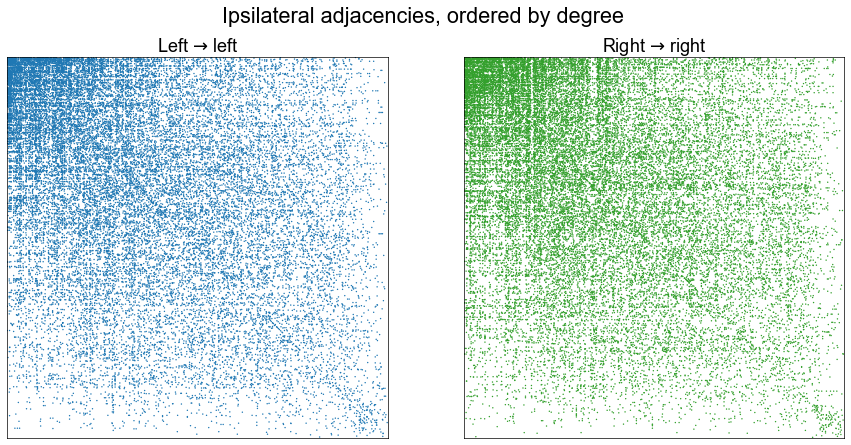

In [3]:


def calculate_weighted_degrees(adj):
    return np.sum(adj, axis=0) + np.sum(adj, axis=1)


def plot_adjs(left, right, title=""):

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    adjplot(
        left,
        item_order=-calculate_weighted_degrees(left),
        plot_type="scattermap",
        sizes=(2, 2),
        ax=axs[0],
        title=r"Left $\to$ left",
        color=palette["Left"],
    )
    adjplot(
        right,
        item_order=-calculate_weighted_degrees(right),
        plot_type="scattermap",
        sizes=(2, 2),
        ax=axs[1],
        title=r"Right $\to$ right",
        color=palette["Right"],
    )
    fig.suptitle(title, ha="center", x=0.51)
    return fig, axs


plot_adjs(ll_adj, rr_adj, title="Ipsilateral adjacencies, ordered by degree")
stashfig("ipsilateral-adj-degree")

In [4]:
n_pairs = len(ll_adj)
relation_dict = dict(zip(np.arange(n_pairs), np.arange(n_pairs)))


def joint_procrustes(
    data1,
    data2,
    method="orthogonal",
    paired_inds1=None,
    paired_inds2=None,
    swap=False,
    verbose=False,
):
    n = len(data1[0])
    if method == "orthogonal":
        procruster = OrthogonalProcrustes()
    elif method == "seedless":
        procruster = SeedlessProcrustes(init="sign_flips")
    elif method == "seedless-oracle":
        X1_paired = data1[0][paired_inds1, :]
        X2_paired = data2[0][paired_inds2, :]
        if swap:
            Y1_paired = data1[1][paired_inds2, :]
            Y2_paired = data2[1][paired_inds1, :]
        else:
            Y1_paired = data1[1][paired_inds1, :]
            Y2_paired = data2[1][paired_inds2, :]
        data1_paired = np.concatenate((X1_paired, Y1_paired), axis=0)
        data2_paired = np.concatenate((X2_paired, Y2_paired), axis=0)
        op = OrthogonalProcrustes()
        op.fit(data1_paired, data2_paired)
        procruster = SeedlessProcrustes(
            init="custom",
            initial_Q=op.Q_,
            optimal_transport_eps=1.0,
            optimal_transport_num_reps=100,
            iterative_num_reps=10,
        )
    data1 = np.concatenate(data1, axis=0)
    data2 = np.concatenate(data2, axis=0)
    currtime = time.time()
    data1_mapped = procruster.fit_transform(data1, data2)
    if verbose > 1:
        print(f"{time.time() - currtime:.3f} seconds elapsed for SeedlessProcrustes.")
    data1 = (data1_mapped[:n], data1_mapped[n:])
    return data1


def ase(adj, n_components=None):
    U, S, Vt = selectSVD(adj, n_components=n_components, algorithm="full")
    S_sqrt = np.diag(np.sqrt(S))
    X = U @ S_sqrt
    Y = Vt.T @ S_sqrt
    return X, Y


def prescale_for_embed(adjs):
    norms = [np.linalg.norm(adj, ord="fro") for adj in adjs]
    mean_norm = np.mean(norms)
    adjs = [adjs[i] * mean_norm / norms[i] for i in range(len(adjs))]
    return adjs

## Plot a graph layout for each hemisphere

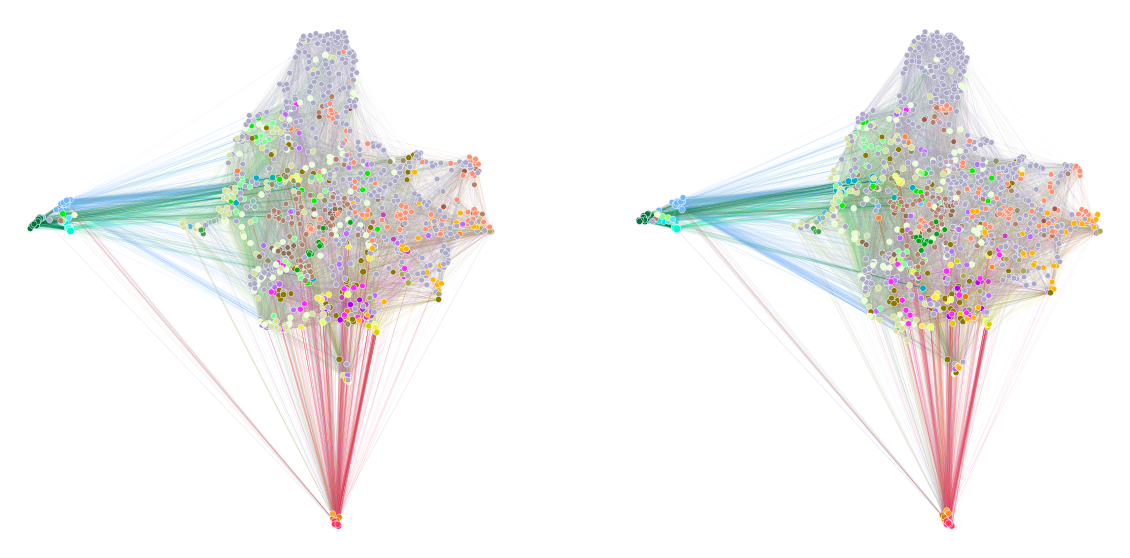

In [5]:
n_components = 32  # 24 looked fine

ll_adj_for_umap = normalize(pass_to_ranks(ll_adj), axis=1)
rr_adj_for_umap = normalize(pass_to_ranks(rr_adj), axis=1)
ll_adj_for_umap = ll_adj_for_umap @ ll_adj_for_umap
rr_adj_for_umap = rr_adj_for_umap @ rr_adj_for_umap

X_ll, Y_ll = ase(ll_adj_for_umap, n_components=n_components)
X_rr, Y_rr = ase(rr_adj_for_umap, n_components=n_components)
# X_ll, Y_ll = joint_procrustes((X_ll, Y_ll), (X_rr, Y_rr), method="orthogonal")

Z_ll = np.concatenate((X_ll, Y_ll), axis=1)
Z_rr = np.concatenate((X_rr, Y_rr), axis=1)
Z_ll, _ = ase(Z_ll, n_components=n_components)
Z_rr, _ = ase(Z_rr, n_components=n_components)


aumap = AlignedUMAP(
    n_neighbors=64,
    min_dist=0.9,
    metric="cosine",
    alignment_regularisation=1e-1,
)
umap_embeds = aumap.fit_transform([Z_ll, Z_rr], relations=[relation_dict])

graphplot_kws = dict(sizes=(30, 60))
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
graphplot(
    network=ll_adj,
    embedding=umap_embeds[0],
    meta=left_nodes,
    hue="merge_class",
    palette=CLASS_COLOR_DICT,
    ax=axs[0],
    **graphplot_kws,
)
graphplot(
    network=rr_adj,
    embedding=umap_embeds[1],
    meta=right_nodes,
    hue="merge_class",
    palette=CLASS_COLOR_DICT,
    ax=axs[1],
    **graphplot_kws,
)
stashfig("aligned-umap-layout")

## Simple statistics for the left hemisphere induced subgraph

In [6]:
ll_mg.sum

,n_nodes,n_edges,sum_edge_weights
edge_type,,,
sum,1211.0,28166.0,90763.0


## Simple statistics for the right hemisphere induced subgraph

In [7]:
rr_mg.sum

,n_nodes,n_edges,sum_edge_weights
edge_type,,,
sum,1210.0,30710.0,101742.0


In [8]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:00:48.818885
Completed at 2021-05-10 14:19:02.358617
----
